## Initial Project

In [133]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight

## Define Data Structure

In [134]:
data_path = '../Dataset/data.csv'
data = pd.read_csv(data_path)

In [135]:
data

,label,data
0,anger,"sok geura leungit atuh sia teh corona, matak g..."
1,anger,"Nu katoel katuhu nu nyerina kenca, goblog wasitna"
2,joy,Bingah pisan patepang sareng pangerasa. Sing k...
3,fear,asa hariwang kieu.. lalakon hirup teh asa nyor...
4,anger,"Orang mana sih anying, sampis pisan. Bunuh ae ..."
...,...,...
2093,joy,Meuni ngeunah ngabarakatak eeeuy uiiiiing....!
2094,joy,"Meuni ku endah, tebeda nami na gusti nu agung,..."
2095,joy,"meuni bungah kieu euy meunang di ngalam, nuhun..."
2096,joy,"Meuni bingah ningalna ya alloh mudah"" PaS 02 k..."


In [136]:
data_snippet = data['data']
data_snippet[3]

'asa hariwang kieu.. lalakon hirup teh asa nyorangan.. asa ieu mah..'

In [137]:
data.loc[3]

label                                                 fear
data     asa hariwang kieu.. lalakon hirup teh asa nyor...
Name: 3, dtype: object

### Stopwords in Sundanese

In [138]:
with open('../Dataset/stopwordv1.txt', 'r') as file:
    stopwords = file.read().splitlines()

In [139]:
stopwords

['tapi',
 'sanajan',
 'salain',
 'ti',
 'ku',
 'kituna',
 'sabalikna',
 'malah',
 'saenggeus',
 'kitu',
 'boh',
 'lain',
 'bae',
 'duka',
 'rek',
 'bari',
 'lantaran',
 'asal',
 'dina',
 'siga',
 'keur',
 'saha',
 'eukeur',
 'wae',
 'atuh',
 'kawas',
 'lamun',
 'erek',
 'isuk',
 'beurang',
 'peuting',
 'kamari',
 'wanci',
 'burit',
 'tengah',
 'teuing',
 'apal',
 'buleud',
 'taneuh',
 'kulon',
 'wetan',
 'kaler',
 'kidul',
 'keur',
 'saha',
 'naon',
 'mana',
 'naha',
 'iraha',
 'kumaha',
 'sabaraha',
 'ieu',
 'eta',
 'dieu',
 'kieu',
 'jeung',
 'sareng',
 'nepi',
 'jaba',
 'lian',
 'lamun',
 'tapi',
 'atawa',
 'atanapi',
 'tuluy',
 'terus',
 'teras',
 'yen',
 'majar',
 'nu',
 'anu',
 'matak',
 'majar',
 'teh',
 'mah',
 'seug',
 'heug',
 'mun',
 'ketah',
 'ketang',
 'pisan',
 'sok',
 'be',
 'wae',
 'we',
 'weh',
 'mung',
 'ngan',
 'ukur',
 'keur',
 'nuju',
 'masih',
 'keneh',
 'pikeun',
 'kanggo',
 'da',
 'kapan',
 'kapanan',
 'apan',
 'pan',
 'apanan',
 'deui',
 'deuih',
 'ge',
 'oge',

In [140]:
import re

def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Tokenize the text
    words = text.split()
    # Remove stopwords
    words = [word for word in words if word not in stopwords]
    # Join words back into a single string
    text = ' '.join(words)
    return text

In [141]:
# before stopwords
data_snippet[3]

'asa hariwang kieu.. lalakon hirup teh asa nyorangan.. asa ieu mah..'

In [142]:
# after stopwords
data_snippet[3] = preprocess_text(data_snippet[3])
data_snippet[3]

'hariwang lalakon hirup nyorangan'

In [143]:
data['processed_text'] = data['data'].apply(preprocess_text)

In [144]:
data['processed_text'].head()

0    geura leungit sia corona gelo yeuh aing unggal...
1           katoel katuhu nyerina kenca goblog wasitna
2    bingah patepang pangerasa sing katampi kalayan...
3                     hariwang lalakon hirup nyorangan
4               orang sih anying sampis bunuh ae bunuh
Name: processed_text, dtype: object

In [148]:
data

,label,data,processed_text
0,anger,"sok geura leungit atuh sia teh corona, matak g...",geura leungit sia corona gelo yeuh aing unggal...
1,anger,"Nu katoel katuhu nu nyerina kenca, goblog wasitna",katoel katuhu nyerina kenca goblog wasitna
2,joy,Bingah pisan patepang sareng pangerasa. Sing k...,bingah patepang pangerasa sing katampi kalayan...
3,fear,hariwang lalakon hirup nyorangan,hariwang lalakon hirup nyorangan
4,anger,"Orang mana sih anying, sampis pisan. Bunuh ae ...",orang sih anying sampis bunuh ae bunuh
...,...,...,...
2093,joy,Meuni ngeunah ngabarakatak eeeuy uiiiiing....!,meuni ngeunah ngabarakatak eeeuy uiiiiing
2094,joy,"Meuni ku endah, tebeda nami na gusti nu agung,...",meuni endah tebeda nami gusti agung dimana bum...
2095,joy,"meuni bungah kieu euy meunang di ngalam, nuhun...",meuni bungah meunang ngalam nuhun bahh nuhun b...
2096,joy,"Meuni bingah ningalna ya alloh mudah"" PaS 02 k...",meuni bingah ningalna alloh mudah pas 02 kenge...


### Define Text and Label

In [149]:
texts = data['processed_text'].astype(str).tolist()
labels = data['label'].tolist()

In [150]:
print("Length of text:", len(texts))
print("Length of label:", len(labels))

Length of text: 2098
Length of label: 2098


### Tokenizer

In [151]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)
encoded_labels = np.array(label_tokenizer.texts_to_sequences(labels)) - 1
encoded_labels = to_categorical(encoded_labels)

In [152]:
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
max_length = max(len(x) for x in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

In [153]:
print("\nTokenized and Padded Sequences:")
print(encoded_labels[:2])


Tokenized and Padded Sequences:
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [154]:
tokenizer.word_index

{'<OOV>': 1,
 'teu': 2,
 'aing': 3,
 'sia': 4,
 'ningali': 5,
 'sieun': 6,
 'nuhun': 7,
 'gusti': 8,
 'aya': 9,
 'meuni': 10,
 'jadi': 11,
 'goblog': 12,
 'hayang': 13,
 'hate': 14,
 'urang': 15,
 'alhamdulillah': 16,
 'abdi': 17,
 'anjing': 18,
 'meni': 19,
 'seuri': 20,
 'bungah': 21,
 'anying': 22,
 'allah': 23,
 'sedih': 24,
 'boga': 25,
 'persib': 26,
 'loba': 27,
 'sarieun': 28,
 'sing': 29,
 'tos': 30,
 'kudu': 31,
 'ngeunah': 32,
 'nikmat': 33,
 'batur': 34,
 'cai': 35,
 'tiasa': 36,
 'bingah': 37,
 'jelema': 38,
 'tong': 39,
 'ayeuna': 40,
 'd': 41,
 'maneh': 42,
 'ah': 43,
 'hariwang': 44,
 'serem': 45,
 'karunya': 46,
 'kana': 47,
 'bagja': 48,
 'beunget': 49,
 'kehed': 50,
 'corona': 51,
 'duh': 52,
 'ningal': 53,
 'kolot': 54,
 'pas': 55,
 'inget': 56,
 'hirup': 57,
 'ai': 58,
 'budak': 59,
 'keueung': 60,
 'siah': 61,
 'tah': 62,
 'panon': 63,
 'yg': 64,
 'imah': 65,
 'bagong': 66,
 'nempo': 67,
 'saredih': 68,
 'jd': 69,
 'ih': 70,
 'alloh': 71,
 'sih': 72,
 'hatur': 73,

In [155]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, encoded_labels, test_size=0.2, random_state=42)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train.argmax(axis=1)), y=y_train.argmax(axis=1))
class_weight_dict = dict(enumerate(class_weights))


In [156]:
from tensorflow.keras.optimizers import Adam

### Model Architecture

The model is a **Bidirectional LSTM Neural Network** for a classification task, structured as follows:

$$
\text{model} = \text{Sequential} \left[
\begin{array}{l}
    \text{Embedding Layer} (\text{input\_dim} = 5000, \text{output\_dim} = 64, \text{input\_length} = \text{max\_length}), \\
    \text{Bidirectional}(\text{LSTM}(64, \text{dropout} = 0.2, \text{recurrent\_dropout} = 0.2)), \\
    \text{Dense}(\text{units} = \text{number of classes}, \text{activation} = \text{'softmax'})
\end{array}
\right]
$$

#### Mathematical Details

1. **Embedding Layer**: Converts each word in the input into a 64-dimensional dense vector representation:
   $$
   \text{Embedding}(V, d) \quad \text{where } V \text{ is the vocabulary size and } d \text{ is the embedding dimension.}
   $$

2. **Bidirectional LSTM**: Processes sequences in both forward and backward directions. Each LSTM unit has:
   $$
   \text{LSTM}(h) \quad \text{where } h \text{ is the number of hidden units.}
   $$
   The LSTM computations include input, forget, and output gates that control the flow of information.

3. **Dropout & Recurrent Dropout**: Introduce regularization to prevent overfitting. Standard dropout applies to the output, while recurrent dropout applies to the hidden states within the LSTM.

4. **Dense Layer with Softmax**: The final dense layer uses a softmax activation to output class probabilities:
   $$
   \text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j} e^{z_j}} \quad \text{for each class } i.
   $$

#### Loss Function and Optimization

1. **Categorical Cross-Entropy Loss**:
   $$
   \text{Loss} = -\sum_{i} y_i \log(\hat{y}_i)
   $$
   where \( y_i \) is the true label and \( \hat{y}_i \) is the predicted probability for class \( i \).

2. **Optimizer**: Adam optimization algorithm, which adjusts learning rates using first and second moments of the gradients.


In [157]:
model = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=max_length),
    Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
    Dense(len(label_tokenizer.word_index), activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()


/Users/mac/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [158]:
history = model.fit(X_train, y_train, epochs=10, validation_split=0.1, class_weight=class_weight_dict)


Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.2737 - loss: 1.3748 - val_accuracy: 0.4821 - val_loss: 1.2475
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7010 - loss: 1.0618 - val_accuracy: 0.8155 - val_loss: 0.7588
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8965 - loss: 0.4755 - val_accuracy: 0.8929 - val_loss: 0.4645
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9550 - loss: 0.2035 - val_accuracy: 0.9048 - val_loss: 0.3861
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9827 - loss: 0.1006 - val_accuracy: 0.8929 - val_loss: 0.3315
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9915 - loss: 0.0557 - val_accuracy: 0.8988 - val_loss: 0.3539
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9969 - loss: 0.0370 - val_accuracy: 0.8988 - val_loss: 0.3336
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9992 - loss: 0.0206 - val_accuracy: 0.9167 - v

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Test Accuracy: 0.92


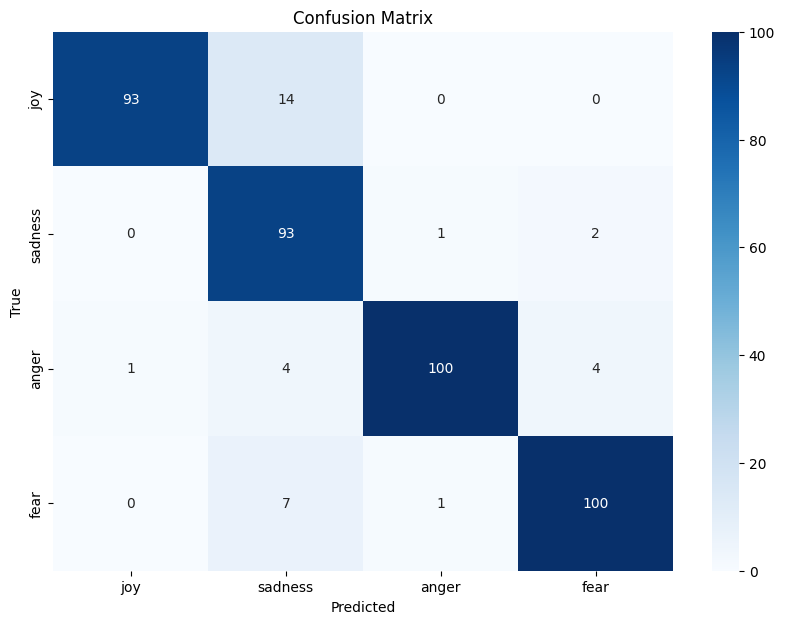

In [159]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Test Accuracy: {accuracy:.2f}")

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_tokenizer.word_index, yticklabels=label_tokenizer.word_index)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [160]:
new_text = """
si kabayan teh kandulan pisan. ari kandulan teh jahe=jago he-es (beuki sare), teu kaop 
nyangkere atawa nyarande sok ker wae kerek. 
 
sakali mangsa si kabayan teh di cukur. di cukurna handapeun tangkal gede disisi jalan 
supratman. ari tukang cukur teh ruruntuk dalang, tadina hayang jadi dalang tapi teu 
kataekan, kalah jadi tukang cukur. teu wudu payu nyukurna teh da eta ari nyukur sok bari 
ngadalang. 
 
si kabayan ti barang gek diuk dina korsi panyukuran geus lelenggutan wae nundutan. saperti 
biasa tukang cukur teh ari ceg kana gunting jeung sisir tuluy wae ngabuih… ngadalang, pok 
na teh…. “tah kacatur keun di nagara alengka, rajana jenengan Dasamuka…. ari dasa hartina 
sapuluh… ari muka eta hartosna beungeut atanapi raray… “. si kabayan nu keur ngalenggut 
ngarasa ka ganggu ku nu keur ngadalang, bari heuay si kabayan nyarita “pondokeun wae 
mang…”  trek-trek tukang cukur teh ngaguntingan buuk si kabayan bari pok deui… ” ari geus 
kitu… eta Dasamuka teh bogoh ka dewi Sinta, geureuhna sri Rama… ” “pondokeun wae 
mang…”ceuk si kabayan nyaritana selang seling antara inget jeung heunteu bakating ku 
tunduh, teu lila reup deui sare….. lilir sakeudeung, tukang cukur teh keur ngadongeng 
keneh, ..” urang tunda dewi Sinta nu keur di Alengka, sabab di paling ku Rahwana…. 
caturkeun sri Rama….” si kabayan asa ka ganggu sarena terus nyarita bari lulungu 
“pondokeun mang….”….terus reup deui peureum. trek..trek tukang cukur ngaguntingan 
buuk si kabayan bari nuluykeun ngadongengna. ari tiap si kabayan lilir, tukang cukur teh 
keur ngabuih keneh wae ngadalang, tapi ari leungeunna mah tetep teu eureun-eureun 
ngaguntingan buuk si kabayan. si kabayan keuheuleun pisan sabab sarena kaganggu ku sora 
tukang cukur, nu sakapeung sok ngagerem nurutan sora buta atawa ngajerit nurutan sora 
dewi sinta basa di paling ku Rahwana… antukna si kabayan ngambek ka tukang cukur bari 
nyarita ” ceuk aing ge pondokeun…pondokeun…” tukang cukur nembalan “dipondokeun 
kumaha ieu geus lenang kieu..” ari ret si kabayan kana eunteung enya wae sirahna geus 
gundul teu sa lembar-lembar acan, puguh wae si kabayan teh ambek “nu dipondokeun teh 
dongeng maneh lain lain buuk aing…” si kabayan morongos, tukang cukur nembalan bari 
nyentak “bongan sorangan, naha atuh sare wae batur di gawe teh, lain nuhun di embohan 
ku dongeng teh…” ngan hing wae si kabayan teh ceurik bakating ku handeueuleun jaba ari 
balik ku barudak di poyokan bari di abring-abring “…penjol….penjol….” 
""".strip()




In [161]:
new_processed_texts = [preprocess_text(text) for text in new_text]

In [162]:
new_text

'si kabayan teh kandulan pisan. ari kandulan teh jahe=jago he-es (beuki sare), teu kaop \nnyangkere atawa nyarande sok ker wae kerek. \n \nsakali mangsa si kabayan teh di cukur. di cukurna handapeun tangkal gede disisi jalan \nsupratman. ari tukang cukur teh ruruntuk dalang, tadina hayang jadi dalang tapi teu \nkataekan, kalah jadi tukang cukur. teu wudu payu nyukurna teh da eta ari nyukur sok bari \nngadalang. \n \nsi kabayan ti barang gek diuk dina korsi panyukuran geus lelenggutan wae nundutan. saperti \nbiasa tukang cukur teh ari ceg kana gunting jeung sisir tuluy wae ngabuih… ngadalang, pok \nna teh…. “tah kacatur keun di nagara alengka, rajana jenengan Dasamuka…. ari dasa hartina \nsapuluh… ari muka eta hartosna beungeut atanapi raray… “. si kabayan nu keur ngalenggut \nngarasa ka ganggu ku nu keur ngadalang, bari heuay si kabayan nyarita “pondokeun wae \nmang…”  trek-trek tukang cukur teh ngaguntingan buuk si kabayan bari pok deui… ” ari geus \nkitu… eta Dasamuka teh bogoh ka de

In [ ]:
another_text = """
Si Kabayan dititah ngala nangka ku mitohana. “Nu kolot ngala nangka téh, Kabayan!” Ceuk mitohana. Kencling Si Kabayan ka kebon, nyorén bedog rék ngala nangka. Barang nepi ka kebon, Si Kabayan alak-ilik kana tangkal nangka. Manggih nu geus kolot hiji tur gedé pisan. Tuluy waé diala. Barang dipanggul kacida beuratna.

“Wah, moal kaduga yeuh mawana, “ pikir Si Kabayan téh. Tuluy wé nangka téh ku Si Kabayan dipalidkeun ka walungan. Jung waé balik ti heula, da geus kolot ieuh!” ceuk Si Kabayan téh nyarita ka nangka.

Barang tepi ka imah, Si Kabayan ditanya ku mitohana.

“Kabayan, meunang ngala nangka téh?”

“Komo wé meunang mah, nya gedé nya kolot,” témbal Si Kabayan.
“Mana atuh ayeuna nangkana?” Mitohana nanya.

“Har, naha can datang kitu? Apan tadi téh dipalidkeun dititah balik ti heula, ceuk Si Kabayan téh.

“Ari manéh, na mana bodo-bodo teuing. Moal enya nangka bisa balik sorangan!” Mitoha Si Kabayan keuheuleun pisan.

“Wah nu bodo mah nangkana, kolot-kolot teu nyaho jalan balik,” ceuk Si Kabayan bari ngaléos.
""".strip()

In [174]:
new_sequences = tokenizer.texts_to_sequences([new_processed_texts])
new_padded_sequences = pad_sequences(new_sequences, maxlen=max_length, padding='post')

In [175]:
emotion_prediction = model.predict(new_padded_sequences)
predicted_emotion = label_tokenizer.index_word[np.argmax(emotion_prediction) + 1]
print("Emosi: ", predicted_emotion)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Emosi:  fear


In [176]:
predicted_classes = (emotion_prediction > 0.5).astype("int32")

In [182]:
for i, text in enumerate(new_text.split("\n")):
    print(f"Text: {text}")
    print(f"Predicted Emotion: {predicted_emotion}")

Text: si kabayan teh kandulan pisan. ari kandulan teh jahe=jago he-es (beuki sare), teu kaop 
Predicted Emotion: fear
Text: nyangkere atawa nyarande sok ker wae kerek. 
Predicted Emotion: fear
Text:  
Predicted Emotion: fear
Text: sakali mangsa si kabayan teh di cukur. di cukurna handapeun tangkal gede disisi jalan 
Predicted Emotion: fear
Text: supratman. ari tukang cukur teh ruruntuk dalang, tadina hayang jadi dalang tapi teu 
Predicted Emotion: fear
Text: kataekan, kalah jadi tukang cukur. teu wudu payu nyukurna teh da eta ari nyukur sok bari 
Predicted Emotion: fear
Text: ngadalang. 
Predicted Emotion: fear
Text:  
Predicted Emotion: fear
Text: si kabayan ti barang gek diuk dina korsi panyukuran geus lelenggutan wae nundutan. saperti 
Predicted Emotion: fear
Text: biasa tukang cukur teh ari ceg kana gunting jeung sisir tuluy wae ngabuih… ngadalang, pok 
Predicted Emotion: fear
Text: na teh…. “tah kacatur keun di nagara alengka, rajana jenengan Dasamuka…. ari dasa hartina 
Predicted

In [198]:
additional_text = """
meni reeus jeng resep ningal barudak diajar macul di sawah. . .
"""


In [199]:
additional_processed_texts = [preprocess_text(text) for text in additional_text]

In [200]:
additional_sequences = tokenizer.texts_to_sequences([additional_processed_texts])
additional_padded_sequences = pad_sequences(additional_sequences, maxlen=max_length, padding='post')


In [201]:
additional_emotion_prediction = model.predict(additional_padded_sequences)
additional_predicted_emotion = label_tokenizer.index_word[np.argmax(additional_emotion_prediction) + 1]
print("Emosi: ", additional_predicted_emotion)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Emosi:  sadness


In [91]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

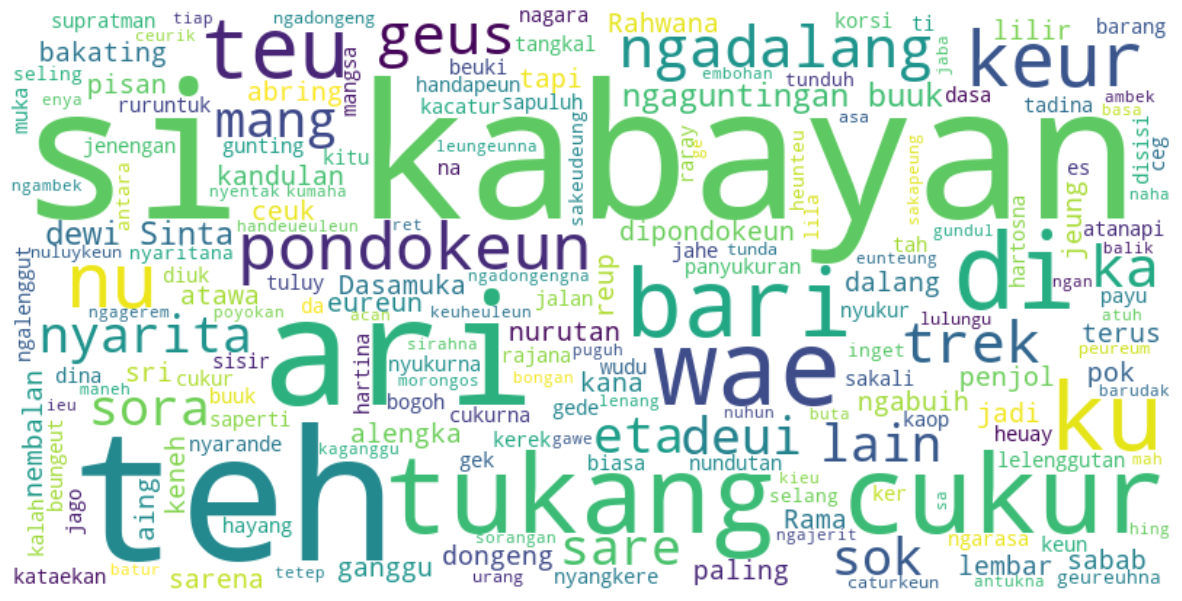

In [92]:
wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(new_text)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [95]:
text = " ".join(review for review in data['processed_text'])

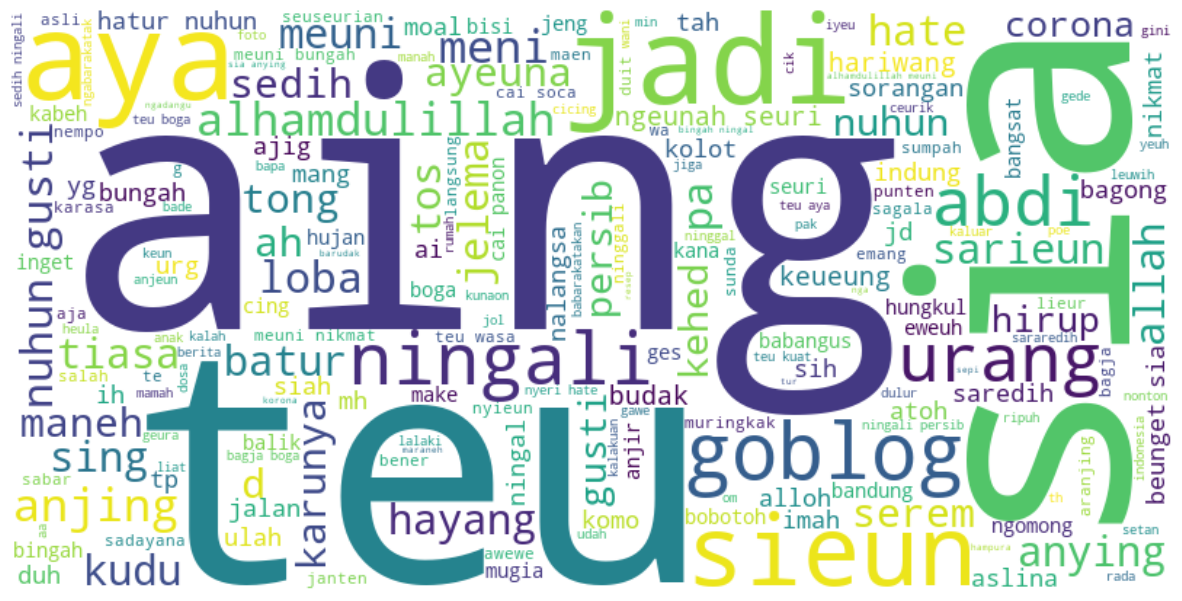

In [96]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [97]:
data_test_path = '../Dataset/test.csv'

In [98]:
data_test = pd.read_csv(data_test_path)

In [99]:
data_test

,label,data
0,fear,meuni asa rame nya crime dimamana... kemarin j...
1,joy,Merinding ningali mic check rrq. Pernah ngasaa...
2,sadness,"mentang2 mamah ges dulur sabelah, meuni te dia..."
3,fear,meni serem atuh pas buka grup keluarga isinya ...
4,sadness,"Meni sedih udah mah ga boleh keluar, di dalem ..."
...,...,...
407,fear,Abi gawe di rs boromeus sararoak kieu:(
408,joy,Abdi teu ngartos tapi abdi seserian ningali si...
409,joy,Aaaaawww meuni bungah kieu aduh
410,joy,"Aa kasep hatur nuhun, eneng bingah pisan ningg..."


In [100]:
data_test_snippet = data_test['data']

In [101]:
data_test_snippet[4]

'Meni sedih udah mah ga boleh keluar, di dalem main game diamuk, serba salah :('

In [102]:
data_test.loc[4]

label                                              sadness
data     Meni sedih udah mah ga boleh keluar, di dalem ...
Name: 4, dtype: object

In [103]:
test_text = """
'Meni sedih udah mah ga boleh keluar, di dalem main game diamuk, serba salah :( '
""".strip()

In [104]:
test_sqeuences = tokenizer.texts_to_sequences([test_text])
test_padded_sequences = pad_sequences(test_sqeuences, maxlen=max_length, padding='post')

In [105]:
test_emotion_prediction = model.predict(test_padded_sequences)
test_predicted_emotion = label_tokenizer.index_word[np.argmax(test_emotion_prediction) + 1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [106]:
print("Emosi: ", test_predicted_emotion)

Emosi:  sadness


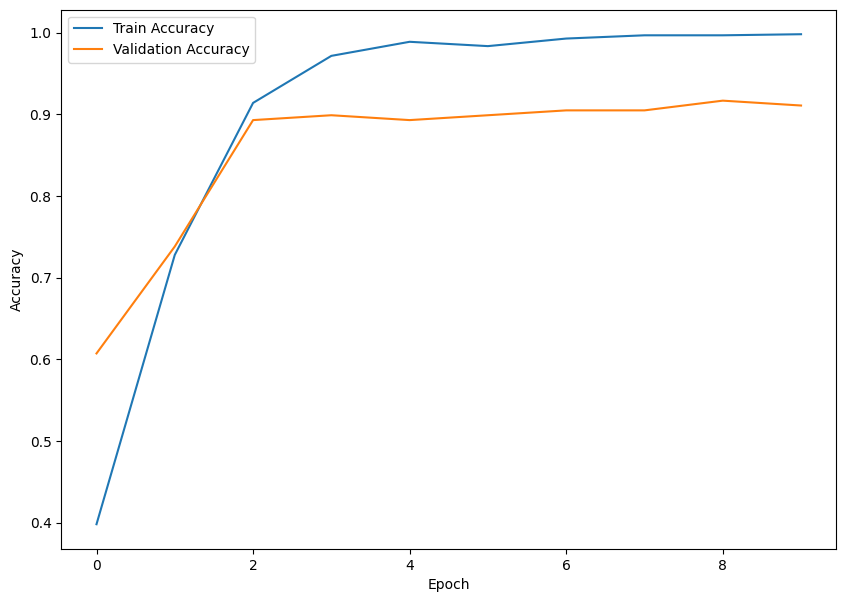

In [107]:
plt.figure(figsize=(10, 7))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

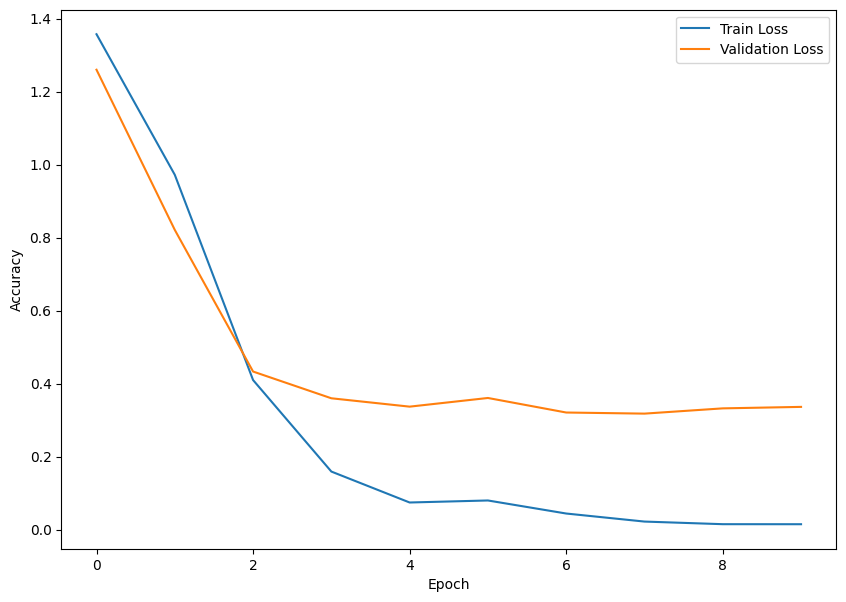

In [108]:
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [109]:
from tensorflow.keras.models import load_model

model_path = 'model.h5'
model.save(model_path)

In [110]:
import pickle

tokenizer_path = 'tokenizer.pkl'
with open(tokenizer_path, 'wb') as f:
    pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [111]:
def load_model_and_tokenizer(model_path, tokenizer_path):
    model = load_model(model_path)
    with open(tokenizer_path, 'rb') as f:
        tokenizer = pickle.load(f)
    return model, tokenizer

model, tokenizer = load_model_and_tokenizer(model_path, tokenizer_path)

In [112]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [113]:
def predicted_emotion(text, tokenizer, model, emotion_label, max_length=100):
    seq = tokenizer.texts_to_sequences([text])
    padded_seq = pad_sequences(seq, maxlen=max_length)
    predictions = model.predict(padded_seq)[0]
    top_indices = np.argsort(predictions)[-3:][::-1]
    top_emotions = [(emotion_label[idx], predictions[idx]) for idx in top_indices]
    return top_emotions

In [115]:
emotion_label_test = data['label'].unique()

In [116]:
emotion_label_test

array(['anger', 'joy', 'fear', 'sadness'], dtype=object)

In [117]:
testing = """
Wah, hate mah asa mekar, seuri teu eureun-eureun! Ngan ukur ngadéngé béja ieu geus ngajadikeun poé ieu pangsaéna.
""".strip()

In [118]:
predicted_emotion(testing, tokenizer, model, emotion_label_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[('sadness', np.float32(0.64491594)),
 ('joy', np.float32(0.24024512)),
 ('fear', np.float32(0.09499159))]